# A simple Product Recommendation process based on product descriptions

### Goal of the project

Given an amazon product description, I'm trying to see how what products will be 'recommended'. For example, if I'm purchasing a Banana Republic t-shirt, I want to see if the recommendation system just recommends other t-shirts or/and other Banana Republic products. For simplicity, I'll first visually inspect the results and then analyze results based on the descriptions.  The original metadata file had information on more than 1.5 million products. This json file has products from the "Clothing, Shoes and Jewelry" category. For this exercise, I'm using information from just 40000 products. 

### Motivation for this project and practical application

Any decent recommender model would have been trained using data from millions of products. For companies like Amazon, sich large amounts of data is easy to come by. But that's not all now is it? Can the same recommender model be used for years at a stretch without any modifications? Probably not. Products evolve over time. Companies do away with older products and bring in  newer ones every day. Companies like Amazon have the time and resources to ensure that their recommendation systems are up to date with the latest trends.

Moreover, neural networks are being used for recommender systems. These models are designed using sophisticated state of the art architecture. The model needs to be designed first. Then it will be tested and modified again and again. Fine tuning deep learning models can be a monumental task. Now, what if I told you that we could come up with a decent recommender process that involves no training at all? Sounds too good to be true? Well, thanks to __[Google's universal-sentence-encoder](https://tfhub.dev/google/universal-sentence-encoder-large/3)__ , this is possible! Given a product description as text, the input will be mapped to a high dimensional vector of length 512. These "embeddings" are then used to compute similarities based on which practical recommendations can be made

### A brief introduction to the Universal Sentence Encoder

This encoder encodes words, phrases, sentences or even paragraphs into high dimensional space. This model was trained extensively using various data sources to accomlish various NLP (Natural Language Processing tasks). 

The input word, phrase, or sentence is converted to a vector of size 512. This vector is represented though a numpy array. What's so special about this encoder is that it maintains context similarity in a semantic sense which can be very useful. For ex, we have the three sentences:

1) How old are you?
2) How are you?
3) What is your age

We know that sentences 1 and 3 are closer in a semantic sense. While sentences 1 and 2 differ only a word, they differ greatly in contrast. The universal sentence encoder was trained such that we compute any mathematical similarity between the 3 sentences, sentences 1 and 3 will be closer than 1 and 2. That's incredible isn't it?

For this project, I'll be using the __[universal-sentence-encoder-large](https://tfhub.dev/google/universal-sentence-encoder-large/3)__. This model was trained with a transformer encoder. We can hope to achive a high accuracy with this model but the tradeoff would be the computing time and memory usage. A lighter version of the universal sentence encoder can be found __[here](https://tfhub.dev/google/universal-sentence-encoder/2)__

In [1]:
import pandas as pd
import json
import ast
import urllib.request
import numpy as np
import cv2
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity

In [2]:
import tensorflow as tf
import tensorflow_hub as hub

We will now only choose the fields of interest

In [3]:
new_df = pd.read_csv('Clothing_file_full.csv')

In [4]:
new_df = new_df[['imUrl', 'title', 'description', 'description_new']].dropna().reset_index(drop=True)

In [5]:
len(new_df)

84031

Now, the sentence embeddings of the product descriptions will be computed.

In [6]:
module_url = "https://tfhub.dev/google/universal-sentence-encoder-large/3"

In [7]:
embed = hub.Module(module_url)

INFO:tensorflow:Using /tmp/tfhub_modules to cache modules.
INFO:tensorflow:Downloading TF-Hub Module 'https://tfhub.dev/google/universal-sentence-encoder-large/3'.
INFO:tensorflow:Downloading https://tfhub.dev/google/universal-sentence-encoder-large/3: 240.00MB
INFO:tensorflow:Downloading https://tfhub.dev/google/universal-sentence-encoder-large/3: 500.00MB
INFO:tensorflow:Downloading https://tfhub.dev/google/universal-sentence-encoder-large/3: 770.00MB
INFO:tensorflow:Downloaded https://tfhub.dev/google/universal-sentence-encoder-large/3, Total size: 810.60MB
INFO:tensorflow:Downloaded TF-Hub Module 'https://tfhub.dev/google/universal-sentence-encoder-large/3'.


In [8]:
all_descriptions = new_df['description_new'].tolist()

In [9]:
len(all_descriptions)

84031

In [10]:
set_1 = all_descriptions[:10000]
set_2 = all_descriptions[10000:20000]
set_3 = all_descriptions[20000:30000]
set_4 = all_descriptions[30000:40000]
set_5 = all_descriptions[40000:50000]
set_6 = all_descriptions[50000:60000]
set_7 = all_descriptions[60000:70000]
set_8 = all_descriptions[70000:80000]
set_9 = all_descriptions[80000:]
full_set = [set_1, set_2, set_3, set_4, set_5, set_6, set_7, set_8, set_9]

In [11]:
tf.logging.set_verbosity(tf.logging.ERROR)
j=0
for i in full_set:
    j += 1
    with tf.device('/device:CPU:0'):      
        with tf.Session() as session:
            session.run([tf.global_variables_initializer(), tf.tables_initializer()])
            description_embeddings  =  session.run(embed(i))
            np.save('clothing_set_full' + str(j) + '.npy', description_embeddings)            
            print(j)
#np.save('embed_10k.npy', description_embeddings)

1
2
3
4
5
6
7
8
9


In [11]:
set_1 = np.load('clothing_set_full1.npy')
set_2 = np.load('clothing_set_full2.npy')
set_3 = np.load('clothing_set_full3.npy')
set_4 = np.load('clothing_set_full4.npy')
set_5 = np.load('clothing_set_full5.npy')
set_6 = np.load('clothing_set_full6.npy')
set_7 = np.load('clothing_set_full7.npy')
#set_8 = np.load('clothing_set_full8.npy')
#set_9 = np.load('clothing_set_full9.npy')

In [12]:
description_embeddings = np.concatenate([set_1, set_2, set_2, set_4, set_5, set_6, set_7])

### STEP 4

In this step, the relative cosine similarities matrix will be computed. For two duplicate images, the computed cosine similarity is 1. If the images are vastly different from one another, the similarity coefficient will be close to 0. Now, the cosine similarity matrix for just the first three images.

In [13]:
cos_matrix = cosine_similarity(description_embeddings)

In [14]:
cos_matrix.shape

(70000, 70000)

We get a square matrix of size 70000x70000.

In the next cell bock, a simple function has been defined to help retrieve the image url and display the product image.

In [15]:
def get_images(url):          
    resp = urllib.request.urlopen(url)                        # This step read the image from the url
    image = np.asarray(bytearray(resp.read()), dtype='uint8') # The read image is then converted to an array
    image = cv2.imdecode(image, cv2.IMREAD_COLOR)             # The images are read keeping the color (RGB) information intact
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    #new_img = cv2.resize(image, (224,224), interpolation=cv2.INTER_CUBIC)
    return image

In the below cell, block the defined function retrieves the closest product descriptions using the computed sentence mebeddings. The 9 closest products will be selected and displayed.

In [16]:
def get_related_products(index_num, data = new_df):
    j = 4 #This variable will be used in the subplots for positioning of the related product items
    similar_prod_arr = cos_matrix[index_num].argsort()[::-1][:10] # Computes the 9 closes product descriptions based on cosin similarity matrix.
    prod_url = new_df['imUrl'].loc[index_num] # Obtaining the URL of the product image
    prod_img = get_images(prod_url) # Retrieving the image from the URL
    fig, ax = plt.subplots(figsize=(19,14))
    plt.subplot(4,3,2)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(prod_img) # Plotting the product image
    plt.title('Product Image',fontsize=14, fontweight='bold')
    for i in similar_prod_arr[1:]:
        url = new_df['imUrl'].loc[i] # Retrieving the image URLs of all relatd products.
        img = get_images(url) # Retrieves the images of all items related to the product
        plt.subplot(4,3,j) 
        plt.xticks([])
        plt.yticks([])
        plt.imshow(img) # Plots the images
        plt.xlabel('Related product index: ' + str(i))
        j+=1

Now, let us jump right in and discover how this "model" would perform as a recommender system.

In [24]:
new_df['description'].loc[38678]

'Cold weather boots that are ideal for everyday winter wear. Double-weave 900D nylon upper with reflective piping. Wrap-around ankle strap for support. 7-layer inner boot system with Thermaplush insulation. Proprietary EVA midsole compound that is cold resistant. Cold-resistant rubber outsole with arch support. Rated to keep you comfortable in temperatures down to -40C/-40F. 12.00" shaft height. 19.75" circumference. 33.50 oz. Features: Outsole: Rubber with integrated arch support Midsole: Proprietary cold resistant EVA compound Base: Synthetic rubber Liner: 7-layer inner boot system with Thermaplush Insole: N/A Upper: Double-weave 900 Denier nylon with reflective piping Fastening System: Locking snow collar '

We have a snow shoes here.

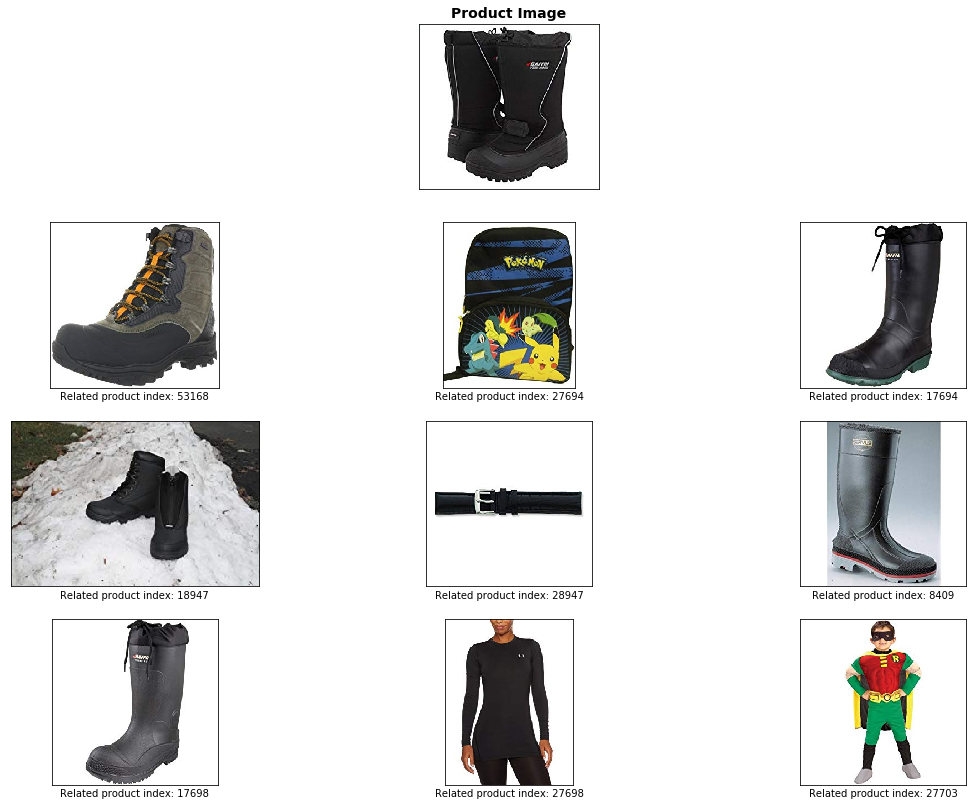

In [23]:
get_related_products(38678)

We get other snow boots that are closest by dscription and even other products that don't seem as related.

In [50]:
new_df['title'].loc[50592]

"Batman Arkham City Joker's Straightjacket Jumpsuit, White, Standard"

We have a Batman jumpsuit from the DC universe.

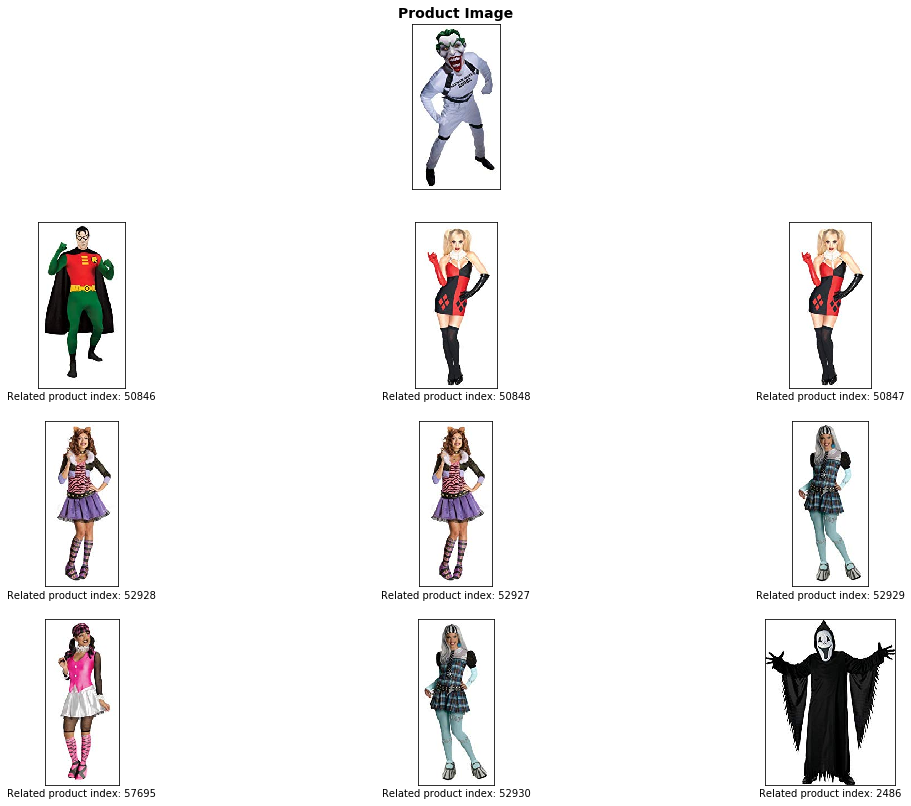

In [27]:
get_related_products(50592)

We get other Halloween related costumes.

In [54]:
new_df['title'].loc[14999]

'Mountain Hardwear NitrousTM Jacket'

In [53]:
new_df['description'].loc[14999]

'Mountain Hardwear Mens NitrousTM Jacket delivers lightweight insulation with 800-fill down in a streamlined package. Made of EcoSensor RipStop nylon, this Jacket is perfect for maximizing heat without adding bulk or puffiness. With a roomy comfortable fit it makes a perfect mid-layer for extreme conditions as well as being ideal to throw on over a shell in milder weather'

We've got a mens jacket here. Let's check out the related products.

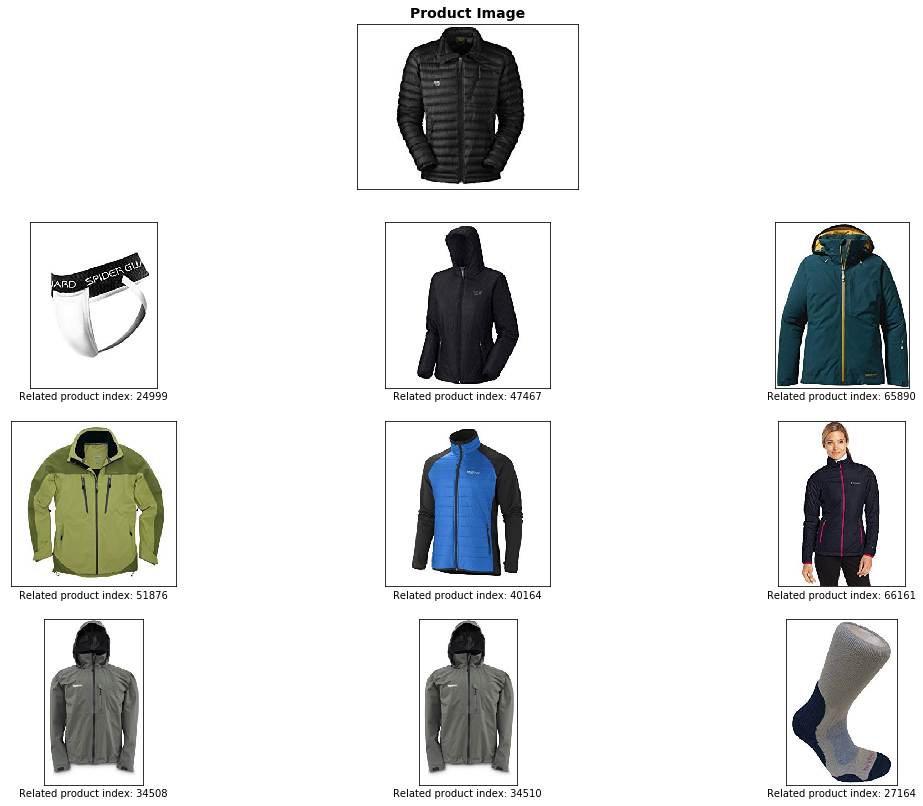

In [34]:
get_related_products(14999)

Most of the related products appear to be other mens jackets

Similarly, let'c check out other products too.

In [44]:
new_df['title'].loc[52156]

'Venture Battery Powered Heated Glove Liners 7.4 Volt - Small - BX923 S'

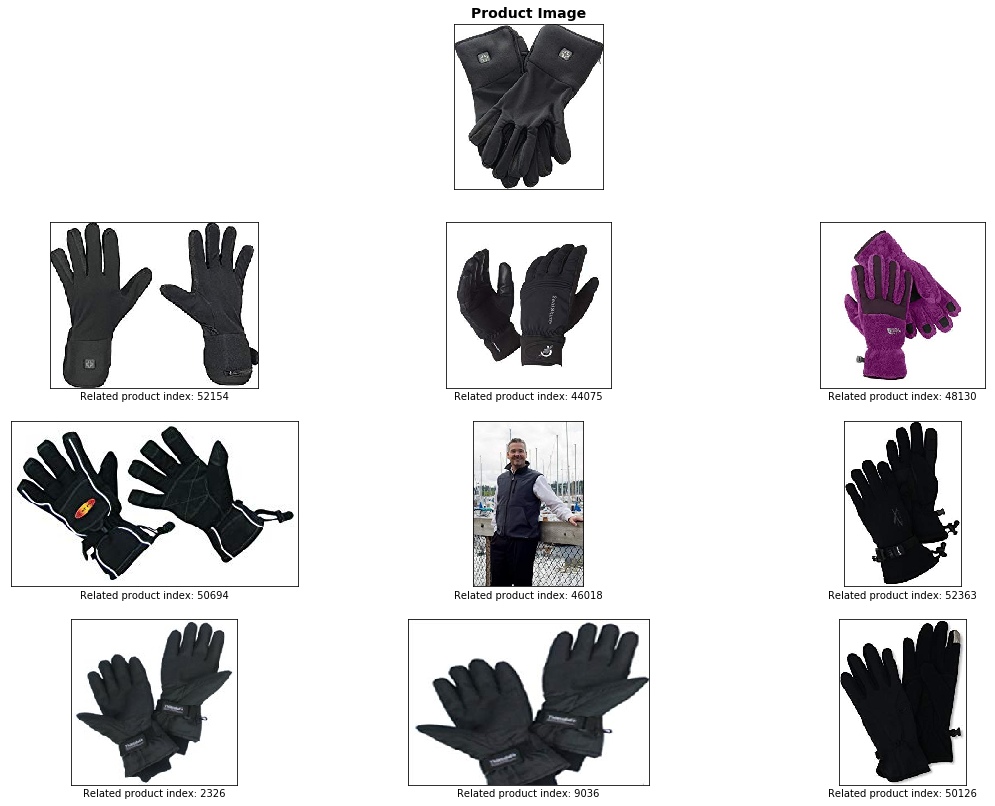

In [43]:
get_related_products(52156)

In [53]:
new_df['title'].loc[52481]

'Angry Birds Black Baseball Cap'

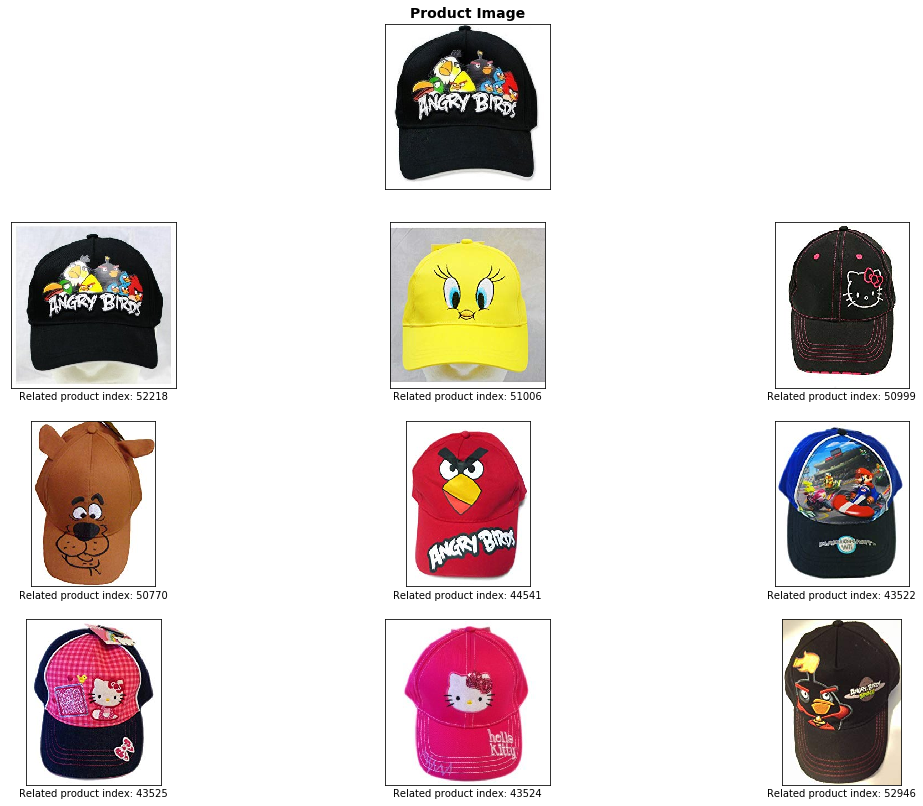

In [46]:
get_related_products(52481)

In [50]:
new_df['title'].loc[16224]

"New Orleans Saints -Black- Women's Dazzle Trim Hooded Sweatshirt - Large"

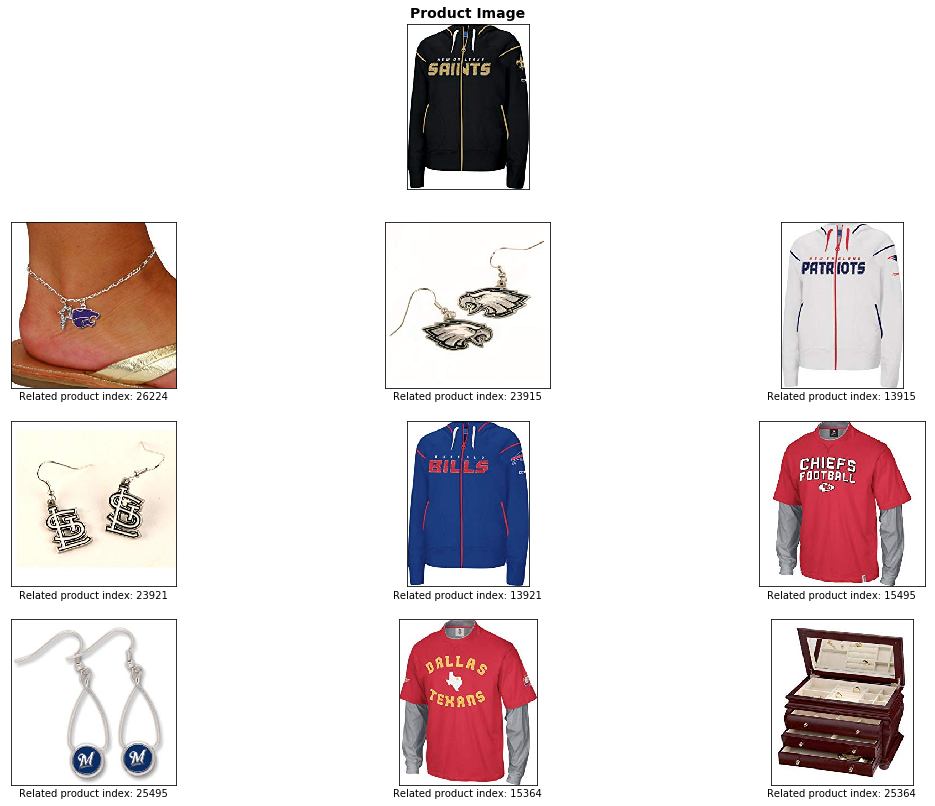

In [51]:
get_related_products(16224)

Indeed, we get recommendations of other **Superman** products.

In [55]:
new_df['title'].loc[32868]

'Disney Princess Pink Digital/ LCD Watch Princesses Cinderella, Tiana and Aurora'

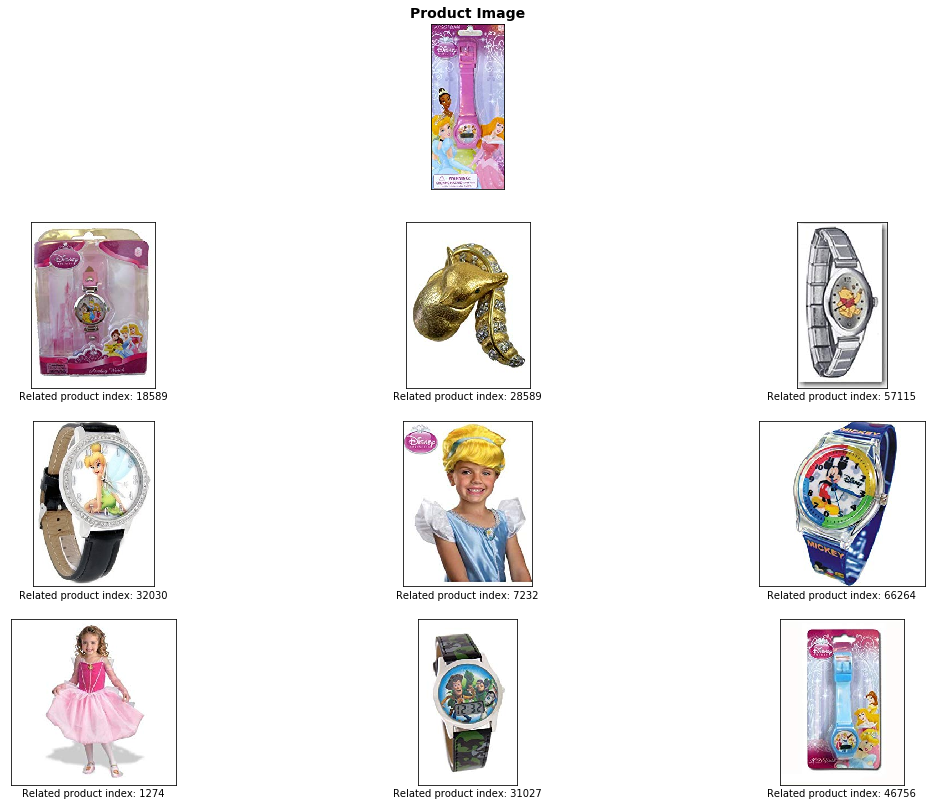

In [53]:
get_related_products(32868)

In [55]:
new_df['title'].loc[63885]

'The Big Bang Theory Bazinga Cape Socks Superman'

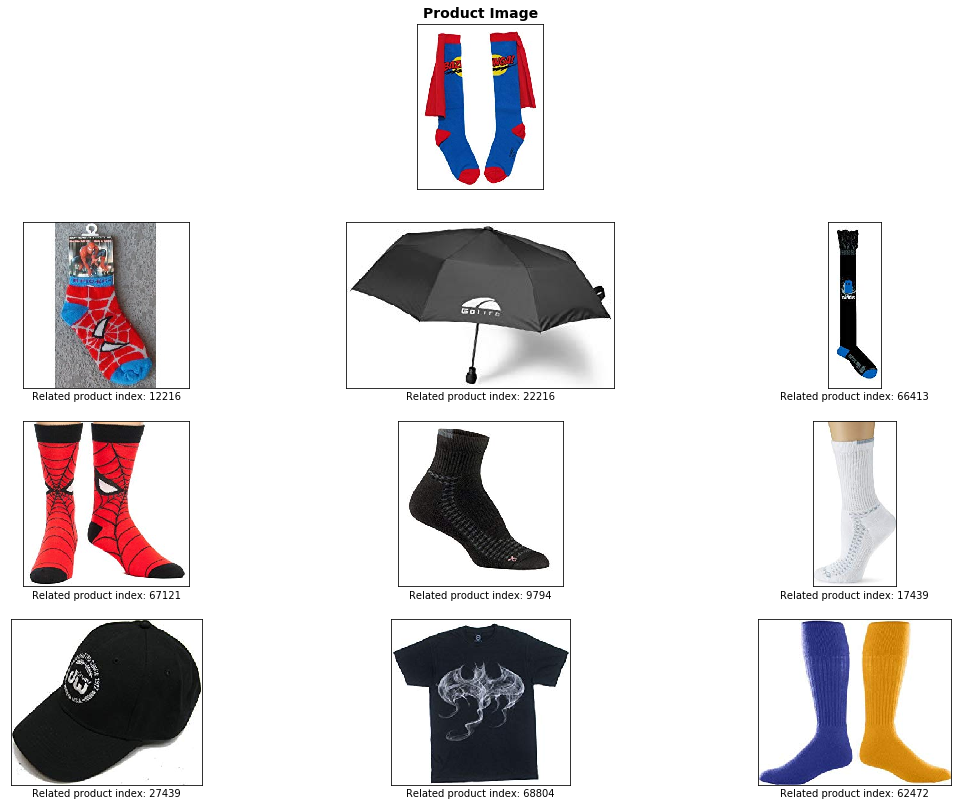

In [56]:
get_related_products(63885)

In [58]:
new_df['title'].loc[13025]

"Nike Women's Victory Dri Fit Tank (Perfect Pink/ White/ Matte Silver) - M"

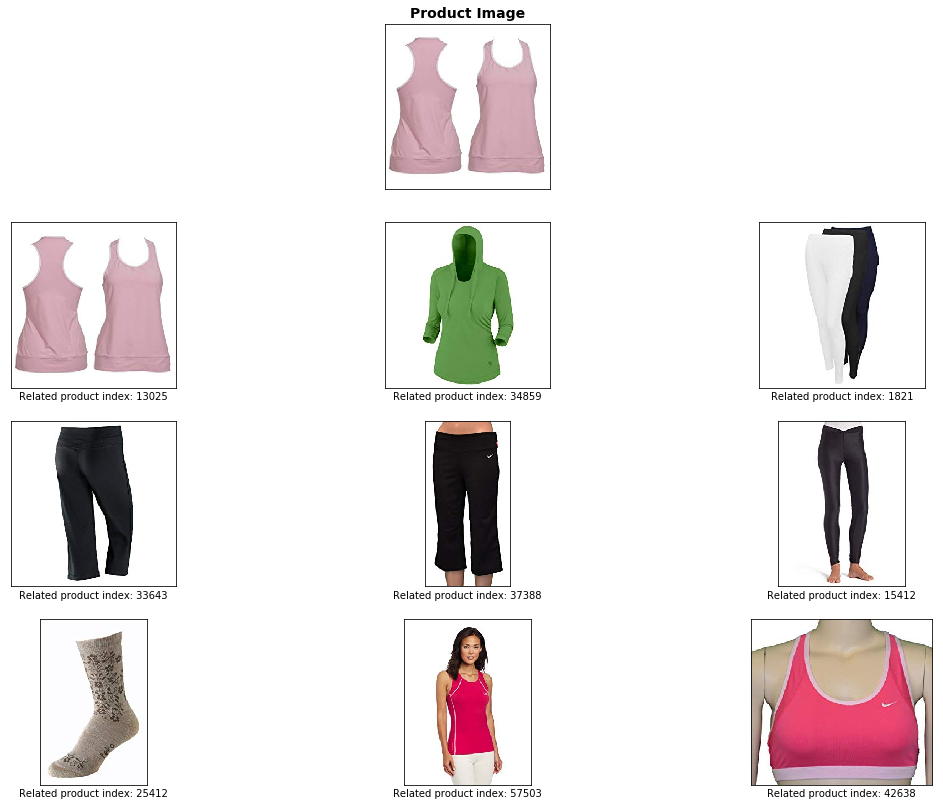

In [60]:
get_related_products(13025)

In [62]:
new_df['title'].loc[5959]

'MyLux Handbag 110517BKWH'

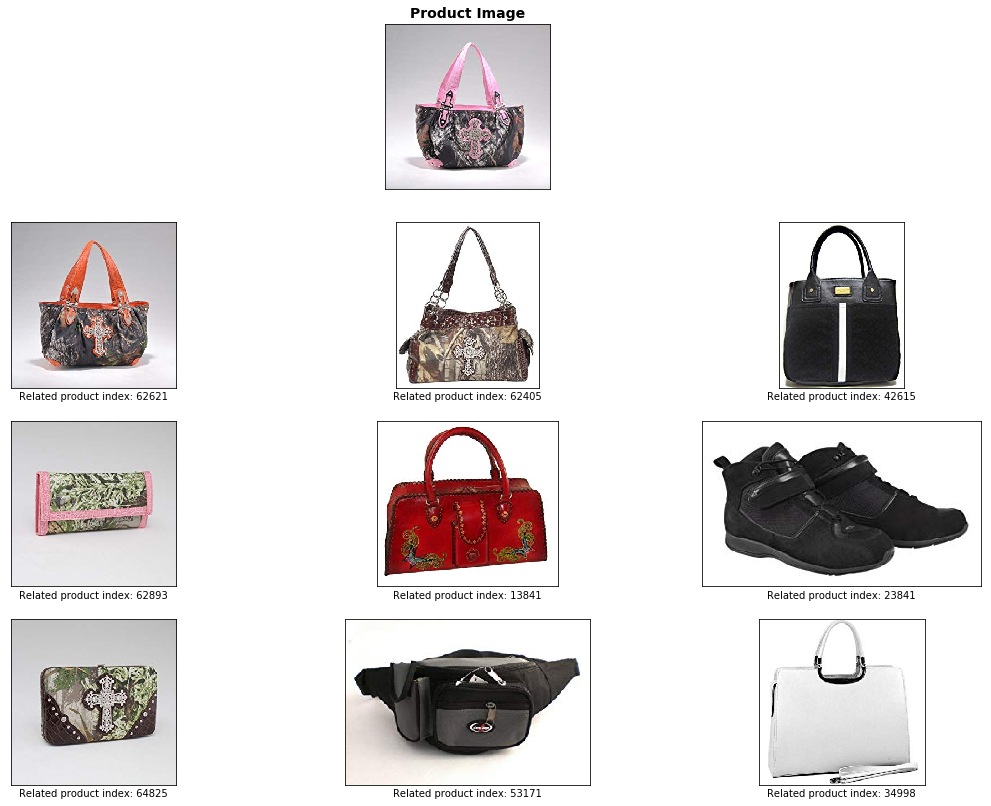

In [78]:
get_related_products(60518)

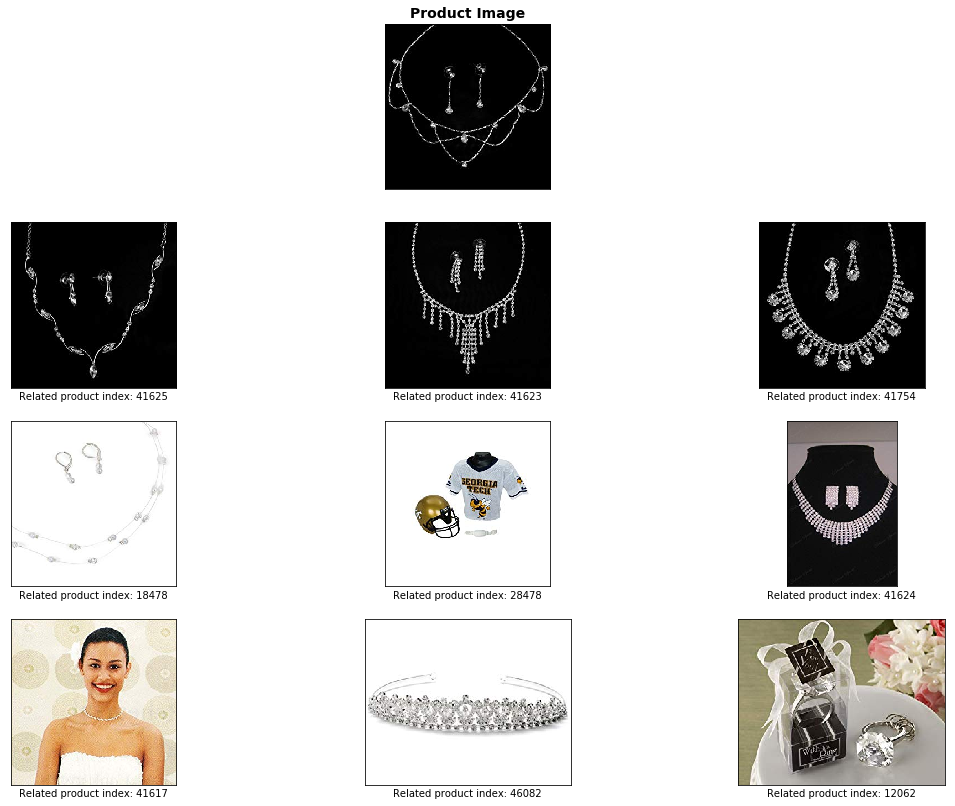

In [83]:
get_related_products(41621)

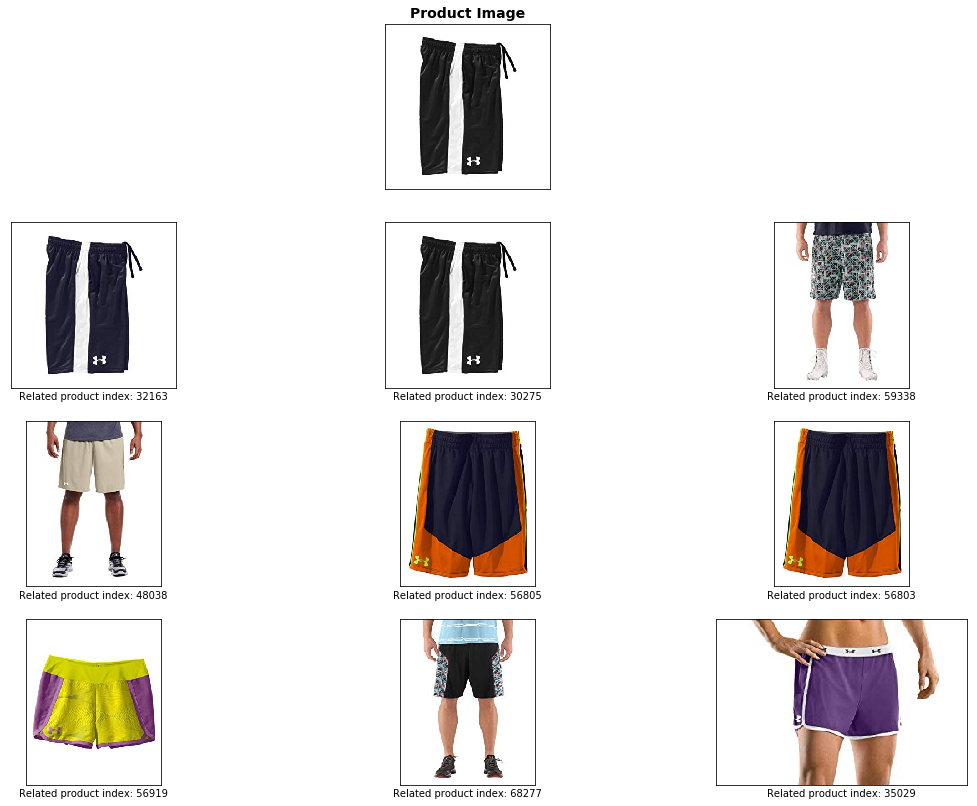

In [99]:
get_related_products(30275)

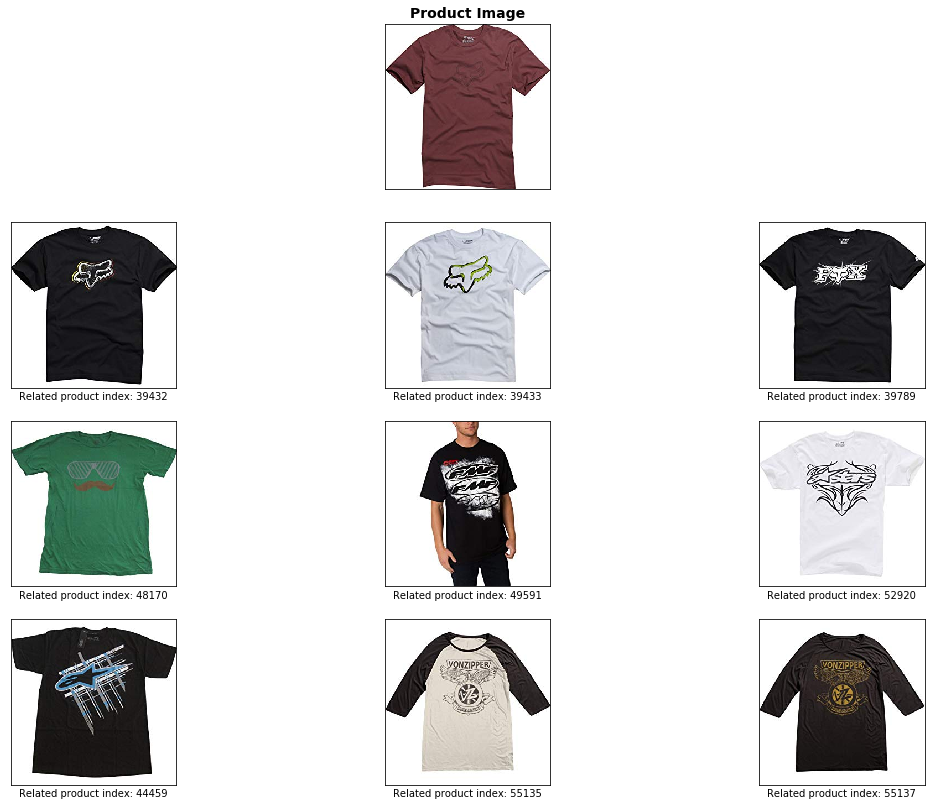

In [110]:
get_related_products(40446)

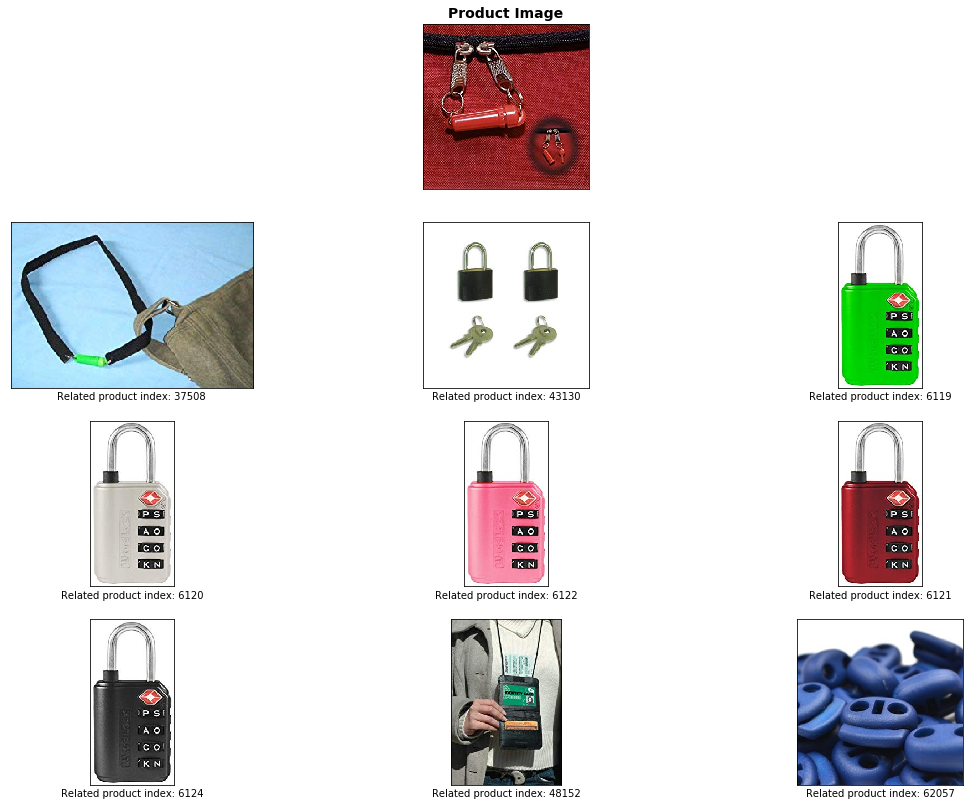

In [112]:
get_related_products(36950)

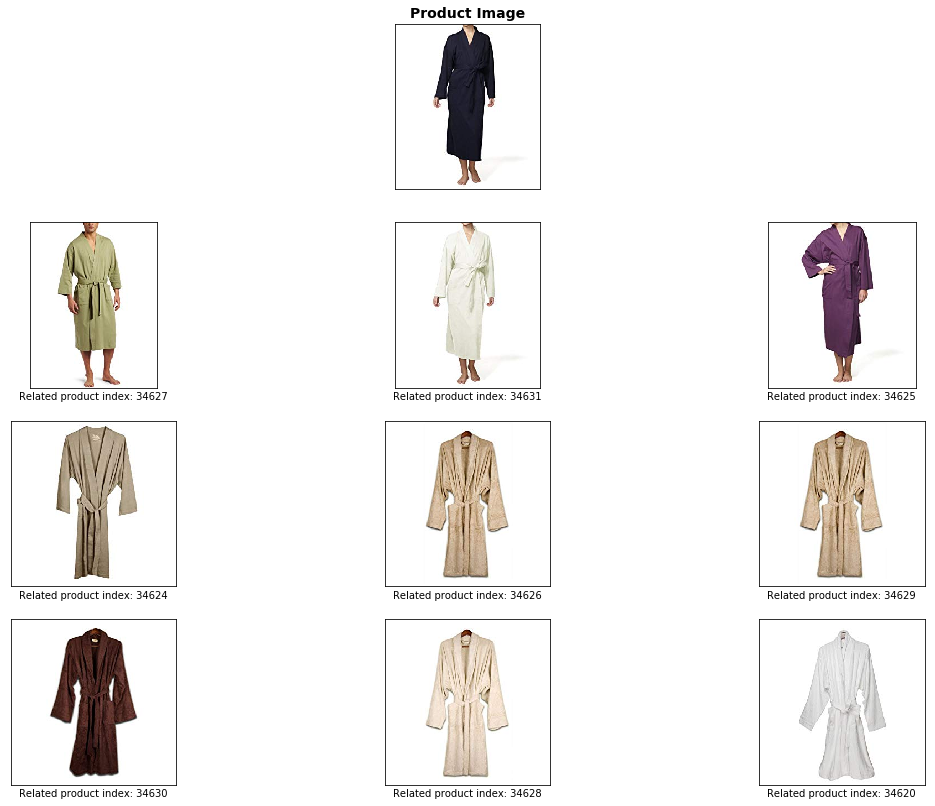

In [125]:
get_related_products(34623)

In [132]:
new_df['title'].loc[8889]

"Brooks W RUN SKORT - Women's ( sz. M, Black/Shadow )"

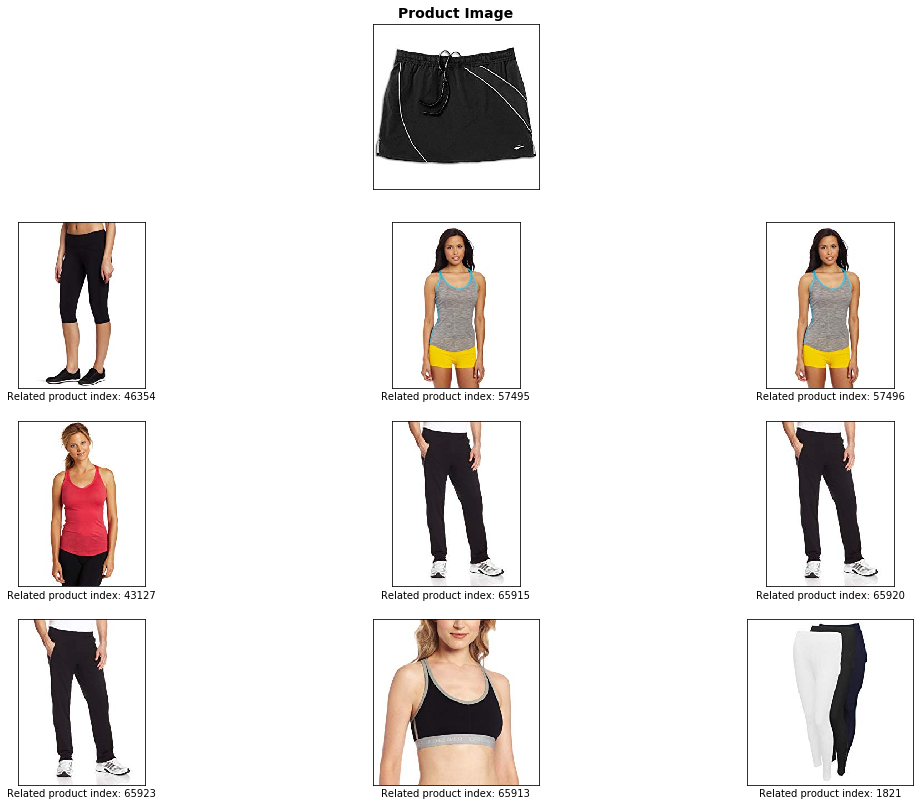

In [130]:
get_related_products(8889)

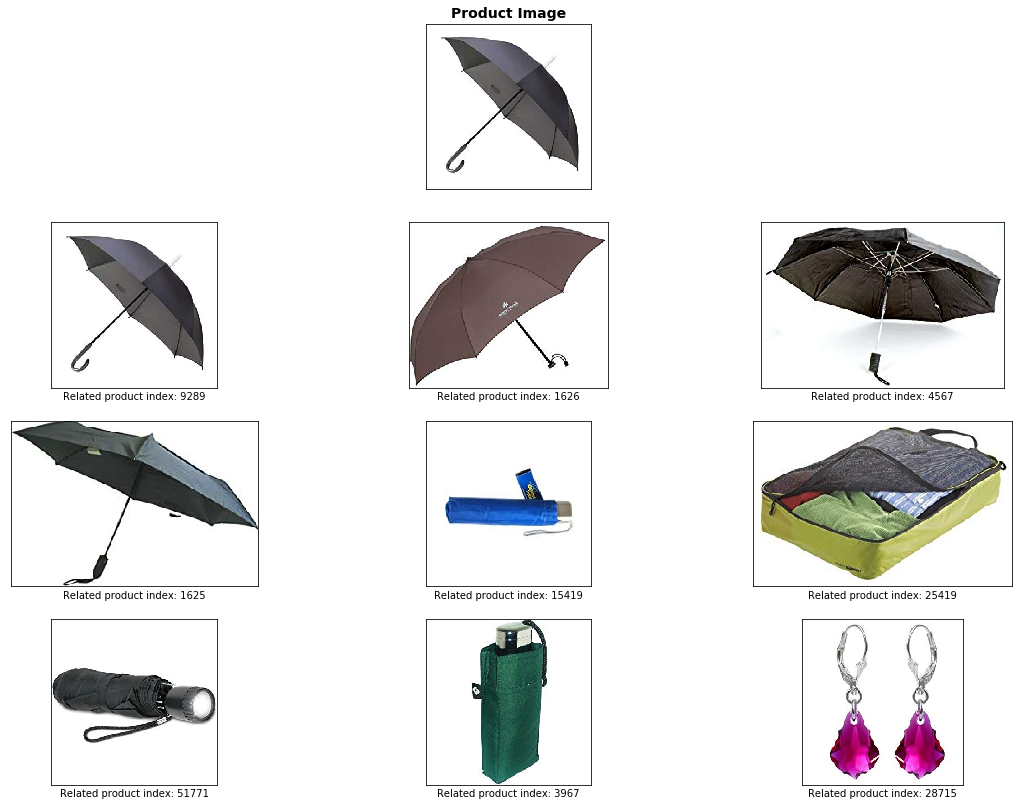

In [134]:
get_related_products(9255)

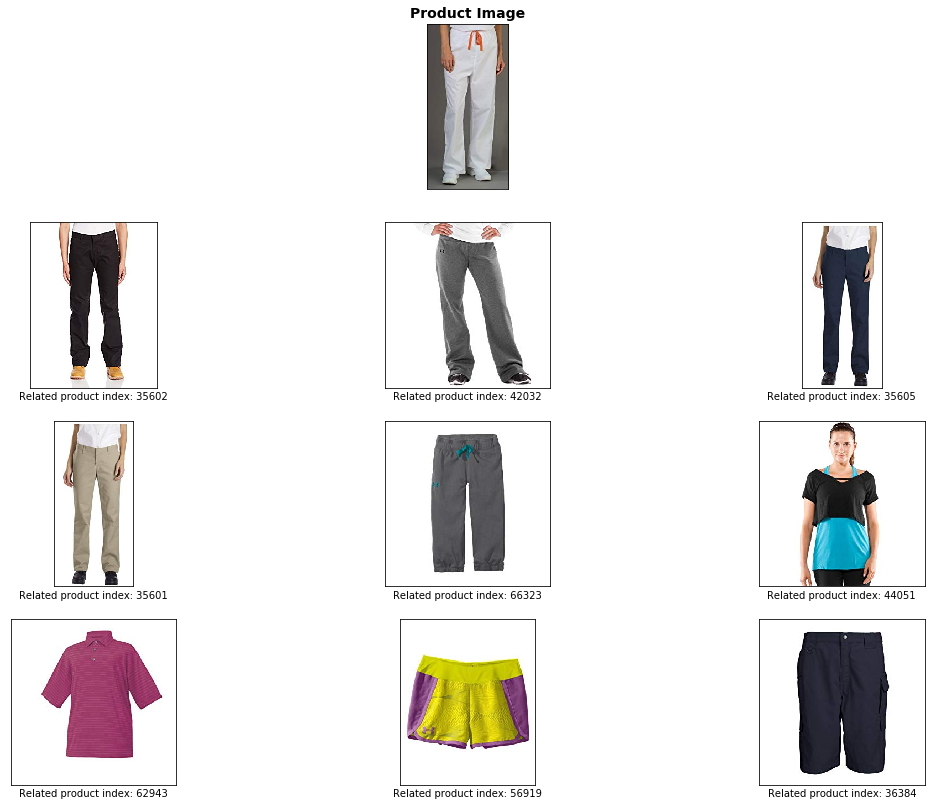

In [145]:
get_related_products(1111)

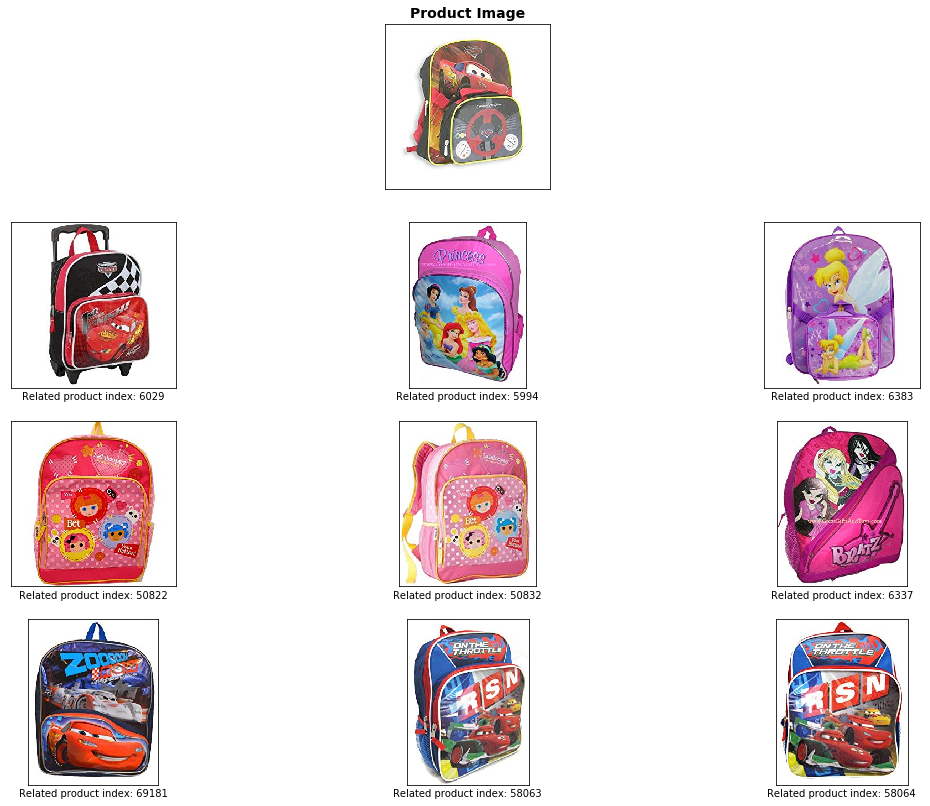

In [168]:
get_related_products(6357)

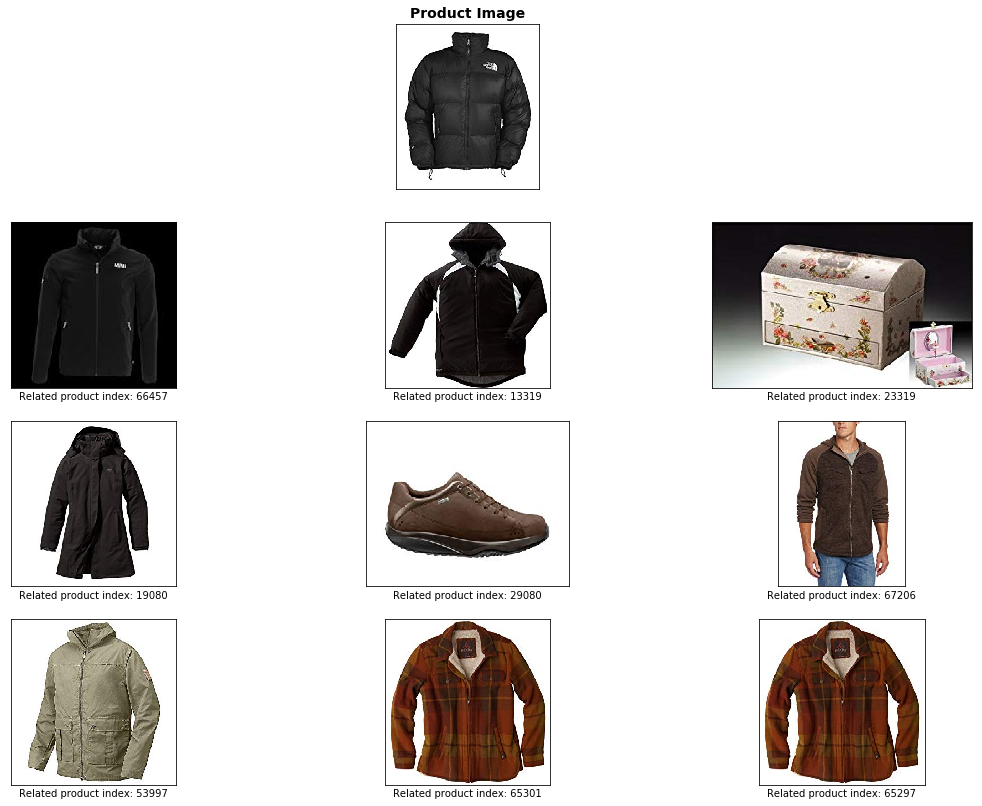

In [25]:
get_related_products(6666)

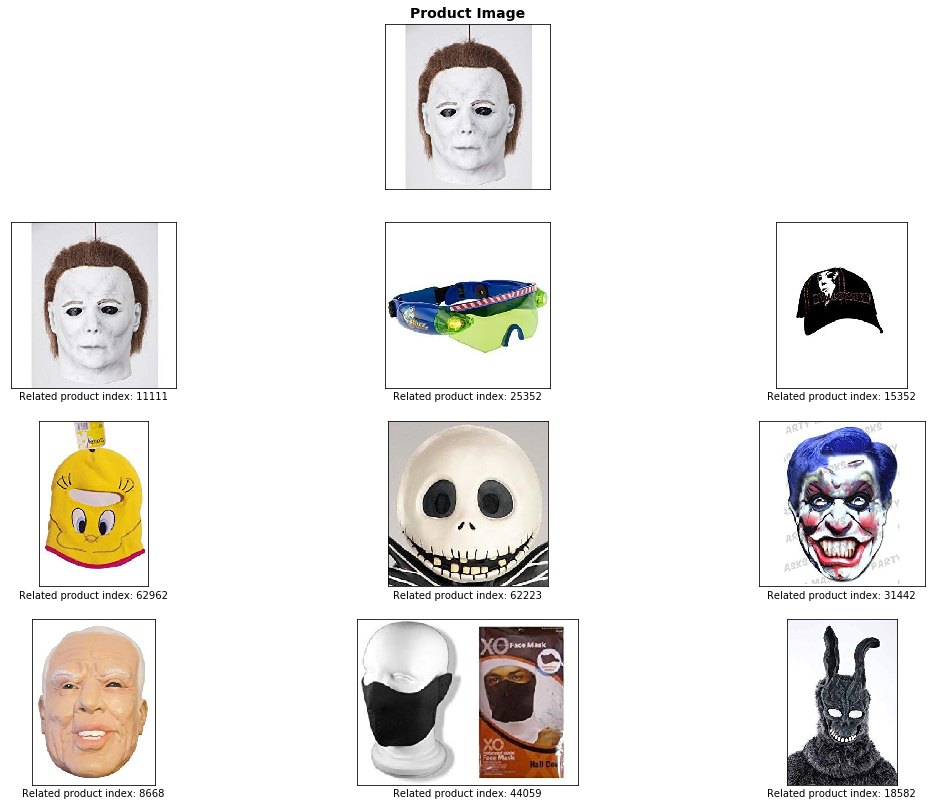

In [30]:
get_related_products(11111)

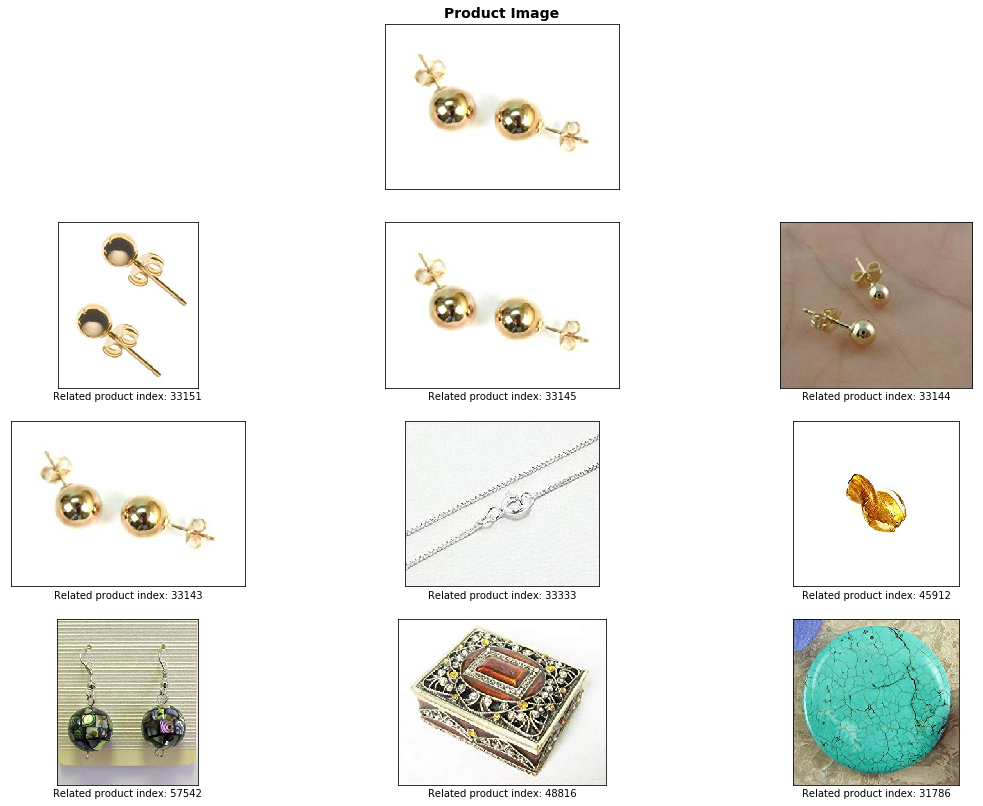

In [33]:
get_related_products(33145)

In [49]:
new_df['description'].loc[18460]

'Way out Western Cowboy Halloween Costume Style! Complete any cowboy Halloween costume with one of our stylish cowboy hats. We have the Cowboy and Cowgirl straw hats you need to make sure that your Cowboy Halloween costume is a hit. One size fits most children. Approximately 20" circumference around inside of hat. Made of straw. Star in center and trim in either Red or Blue. This cowboy costume hat is the perfect accessory for any cowboy Halloween costume, or western theme event. This cowboy hat is the perfect cowboy costume hat for you when you\'re headin\' out west! Part of Costumes > Hats & Wigs > Cowboy & Western'

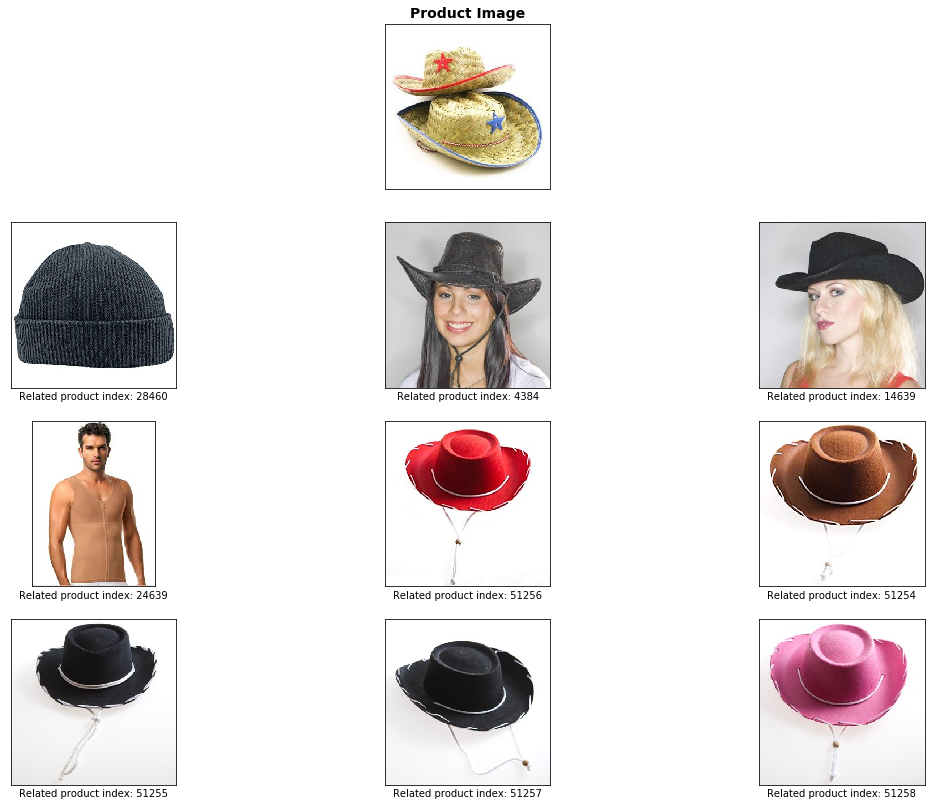

In [45]:
get_related_products(18460)